In [160]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks

In [161]:
x_test, y_test = load_cifar10(n_examples=2)

In [162]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x, gradient_routing = False, return_routed_act=False):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        act = self.pool2(x)

        if gradient_routing:
            mask = torch.zeros_like(act)
            mask[:, :64, ...] = 1 # half of values become 1
            x = mask * act + (1 - mask) * act.detach() # from https://arxiv.org/pdf/2410.04332
        else:
            x = act

        routed_activation = x.clone().detach()
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
            
        if return_routed_act:
            return x, routed_activation
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [163]:
trainloader, testloader = load_cifar10()

In [164]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [165]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=24/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


def get_targeted_attack_imgs(clean_imgs, clean_labels):
    # get random labels for targeted attack!
    adv_targets = torch.randint(0, 9, clean_labels.shape, device=device)
    adv_targets = torch.where(adv_targets >= clean_labels, adv_targets + 1, adv_targets)

    # print(clean_imgs.shape)
    adv_images = pgd(clean_imgs, adv_targets)
    
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        _, predicted = torch.max(outputs, 1)
    
    success_rate = (predicted == adv_targets).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')

    succ_adv_imgs = adv_images[predicted == adv_targets]
    adv_targets = adv_targets[predicted == adv_targets]
    print(f'{len(succ_adv_imgs)} successful adversarial imgs')
    return succ_adv_imgs, adv_targets

# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            succ_adv_imgs, adv_targets = get_targeted_attack_imgs(inputs, targets)

            optimizer.zero_grad()
            
            outputs, routed_act_clean = model(inputs, return_routed_act=True)
            adv_outputs, routed_act_dirty = model(succ_adv_imgs, gradient_routing=True, return_routed_act=True)

            # mask = torch.zeros_like(routed_act_dirty)
            # mask[:, :64, ...] = 1
            print("clean norm", torch.sum(torch.abs(routed_act_clean[:, :64, ...])))
            print("dirty norm", torch.sum(torch.abs(routed_act_dirty[:, :64, ...])))
  
            loss = criterion(outputs, targets) + criterion(adv_outputs, adv_targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

In [166]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(9734.5000, device='mps:0')
dirty norm tensor(1014.7092, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5649, Acc: 7.03%
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(16812.4688, device='mps:0')
dirty norm tensor(2008.4172, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(43608.6875, device='mps:0')
dirty norm tensor(5645.2793, device='mps:0')
Attack success rate: 14.06%
18 successful adversarial imgs
clean norm tensor(66827.6562, device='mps:0')
dirty norm tensor(11073.1719, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(35582.1094, device='mps:0')
dirty norm tensor(3480.0527, device='mps:0')
Attack success rate: 11.72%
15 successful adversarial imgs
clean norm tensor(21806.2617, device='mps:0')
dirty norm tensor(3003.1985, device='mps:0')
Attack success 

In [157]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(6811.0078, device='mps:0')
dirty norm tensor(615.4380, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5583, Acc: 10.94%
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(10040.6895, device='mps:0')
dirty norm tensor(877.0325, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(22744.7188, device='mps:0')
dirty norm tensor(2158.6272, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(50696.3203, device='mps:0')
dirty norm tensor(5955.9912, device='mps:0')
Attack success rate: 9.38%
12 successful adversarial imgs
clean norm tensor(29346.8867, device='mps:0')
dirty norm tensor(3233.3669, device='mps:0')
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(19587.2266, device='mps:0')
dirty norm tensor(1639.0381, device='mps:0')
Attack success rate: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x107d4c720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [ ]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)

In [ ]:
import os

filepath='model.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)

# Save the model state dict
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

In [ ]:
os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
   
# Save the model state dict
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

In [9]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=5)


Starting training...
Training on mps
Epoch: 1/5, Batch: 0, Loss: 2.3026, Acc: 12.50%
Epoch: 1/5, Batch: 100, Loss: 1.9068, Acc: 22.89%
Epoch: 1/5, Batch: 200, Loss: 1.5944, Acc: 28.66%
Epoch: 1/5, Batch: 300, Loss: 1.4324, Acc: 33.14%
Epoch 1 completed: Loss: 1.7081, Accuracy: 36.44%
Epoch: 2/5, Batch: 0, Loss: 1.4737, Acc: 41.41%
Epoch: 2/5, Batch: 100, Loss: 1.2099, Acc: 52.02%
Epoch: 2/5, Batch: 200, Loss: 1.0808, Acc: 53.33%
Epoch: 2/5, Batch: 300, Loss: 1.1116, Acc: 54.79%
Epoch 2 completed: Loss: 1.2104, Accuracy: 56.05%
Epoch: 3/5, Batch: 0, Loss: 0.9632, Acc: 65.62%
Epoch: 3/5, Batch: 100, Loss: 1.0346, Acc: 62.96%
Epoch: 3/5, Batch: 200, Loss: 0.9848, Acc: 63.93%
Epoch: 3/5, Batch: 300, Loss: 0.7750, Acc: 64.62%
Epoch 3 completed: Loss: 0.9768, Accuracy: 65.13%
Epoch: 4/5, Batch: 0, Loss: 0.8693, Acc: 68.75%
Epoch: 4/5, Batch: 100, Loss: 0.8879, Acc: 67.86%
Epoch: 4/5, Batch: 200, Loss: 0.9032, Acc: 68.98%
Epoch: 4/5, Batch: 300, Loss: 0.6599, Acc: 69.16%
Epoch 4 completed: L

In [8]:
# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [13]:
# Visualization function
def show_sample_predictions(model, testloader, num_samples=8):
    device = 'mps'
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Denormalize for visualization
    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        
        # Denormalize image
        img = images[i].cpu() # * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        plt.imshow(img)
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Evaluating model...

Overall Test Accuracy: 78.25%

Per-class accuracies:
plane: 84.70%
car: 89.20%
bird: 72.70%
cat: 65.90%
deer: 77.00%
dog: 55.00%
frog: 92.70%
horse: 73.30%
ship: 87.90%
truck: 84.10%


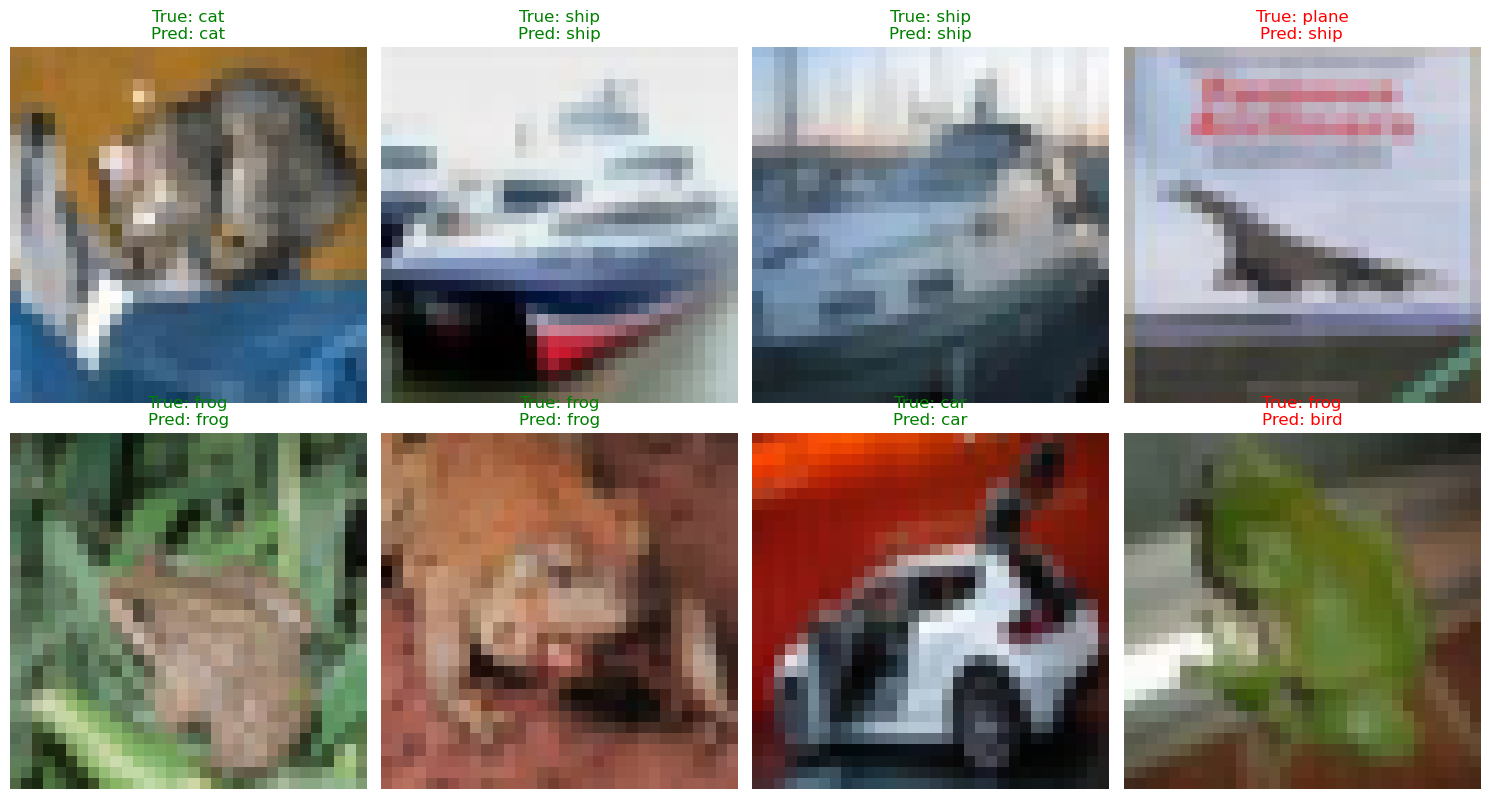

In [14]:
# Evaluate model
print("\nEvaluating model...")
test_accuracy = evaluate_model(model, testloader)

# Show sample predictions
show_sample_predictions(model, testloader)

In [29]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

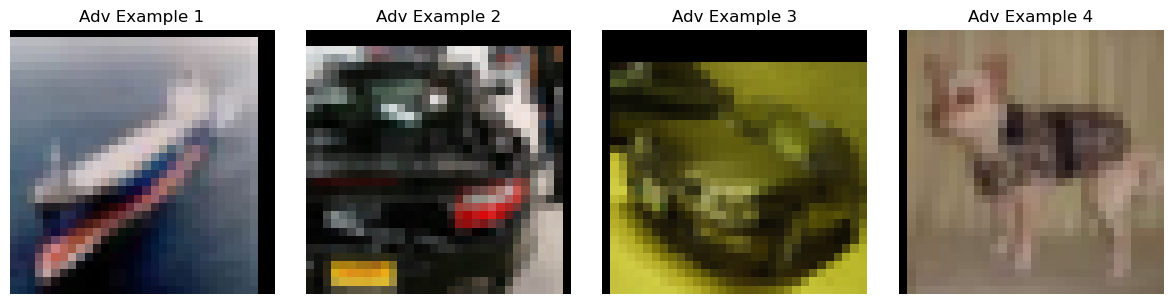

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (5x16384 and 4096x512)

In [78]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=32/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in trainloader:
    # print(images.shape); break
    images, labels = images.to(device)[:5], labels.to(device)[:5]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [43]:
adv_images.shape

torch.Size([5, 3, 32, 32])

In [44]:
labels

tensor([4, 3, 1, 2, 7], device='mps:0')